In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import torch.nn.functional as F
import seaborn as sns
from models.unet import UNet
from datasets.BRATS2018 import NormalizeBRATS, ToTensor

%matplotlib inline

In [35]:
def visualize(model_path, device, base_path, img_name):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    brats_colors = [[0, 0, 0], [192, 132, 0], [132, 0, 192], [0, 192, 132]]
    brats_classes = ['background', 'necrotic tumor', 'peritumoral edema', 'enhancing tumor']
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    gt_path = os.path.join(base_path, img_name + '_seg.npy')
    
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(brats_colors):
        ind2color[ind] = (color, brats_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    ax1.set_title('original image')
    sc = np.load(scan_path)
    gt = np.load(gt_path)
    assert sc.shape == (4, 240, 240)
    assert gt.shape == (240, 240)
    ax1.imshow(sc[1])
    
    model = UNet(4, 4, residual=True, expansion=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    normalize_brats = NormalizeBRATS()
    to_tensor = ToTensor()
    
    sc, gt = normalize_brats((sc, gt))
    sc, gt = to_tensor((sc, gt))
    
    sc = sc.to(device)
    gt = gt.to(device)
    
    # unsqueeze to 4 dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    with torch.no_grad():
        output = model(sc)
        pred = torch.argmax(F.softmax(output, dim=1), dim=1, keepdim=True)
    
    # squeeze back to 2 dimension HxW
    pred = torch.squeeze(pred)
    
    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()
    
    height, width = pred.shape
    colored_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
            
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)
    
    height, width = gt.shape
    colored_gt = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_gt[h, w] = ind2color[gt[h, w]][0]
    
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=brats_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(colored_gt)
    

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
base_path = 'BRATS2018/seg/val/'

In [28]:
!ls BRATS2018/seg/val

Brats18_TCIA04_192_1_020_et.npy    Brats18_TCIA06_409_1_020_et.npy
Brats18_TCIA04_192_1_020_scan.npy  Brats18_TCIA06_409_1_020_scan.npy
Brats18_TCIA04_192_1_020_seg.npy   Brats18_TCIA06_409_1_020_seg.npy
Brats18_TCIA04_192_1_020_tc.npy    Brats18_TCIA06_409_1_020_tc.npy
Brats18_TCIA04_192_1_020_wt.npy    Brats18_TCIA06_409_1_020_wt.npy
Brats18_TCIA04_192_1_021_et.npy    Brats18_TCIA06_409_1_021_et.npy
Brats18_TCIA04_192_1_021_scan.npy  Brats18_TCIA06_409_1_021_scan.npy
Brats18_TCIA04_192_1_021_seg.npy   Brats18_TCIA06_409_1_021_seg.npy
Brats18_TCIA04_192_1_021_tc.npy    Brats18_TCIA06_409_1_021_tc.npy
Brats18_TCIA04_192_1_021_wt.npy    Brats18_TCIA06_409_1_021_wt.npy
Brats18_TCIA04_192_1_022_et.npy    Brats18_TCIA06_409_1_022_et.npy
Brats18_TCIA04_192_1_022_scan.npy  Brats18_TCIA06_409_1_022_scan.npy
Brats18_TCIA04_192_1_022_seg.npy   Brats18_TCIA06_409_1_022_seg.npy
Brats18_TCIA04_192_1_022_tc.npy    Brats18_TCIA06_409_1_022_tc.npy
Brats18_TCIA04_192_1_022_wt.npy    Brats18_TCIA06_409

Brats18_TCIA05_478_1_127_seg.npy   Brats18_TCIA08_242_1_127_seg.npy
Brats18_TCIA05_478_1_127_tc.npy    Brats18_TCIA08_242_1_127_tc.npy
Brats18_TCIA05_478_1_127_wt.npy    Brats18_TCIA08_242_1_127_wt.npy
Brats18_TCIA05_478_1_128_et.npy    Brats18_TCIA08_242_1_128_et.npy
Brats18_TCIA05_478_1_128_scan.npy  Brats18_TCIA08_242_1_128_scan.npy
Brats18_TCIA05_478_1_128_seg.npy   Brats18_TCIA08_242_1_128_seg.npy
Brats18_TCIA05_478_1_128_tc.npy    Brats18_TCIA08_242_1_128_tc.npy
Brats18_TCIA05_478_1_128_wt.npy    Brats18_TCIA08_242_1_128_wt.npy
Brats18_TCIA05_478_1_129_et.npy    Brats18_TCIA08_242_1_129_et.npy
Brats18_TCIA05_478_1_129_scan.npy  Brats18_TCIA08_242_1_129_scan.npy
Brats18_TCIA05_478_1_129_seg.npy   Brats18_TCIA08_242_1_129_seg.npy
Brats18_TCIA05_478_1_129_tc.npy    Brats18_TCIA08_242_1_129_tc.npy
Brats18_TCIA05_478_1_129_wt.npy    Brats18_TCIA08_242_1_129_wt.npy
Brats18_TCIA05_478_1_130_et.npy    Brats18_TCIA08_242_1_130_et.npy
Brats18_TCIA05_478_1_130_scan.npy  Brats18_TCIA08_242_1

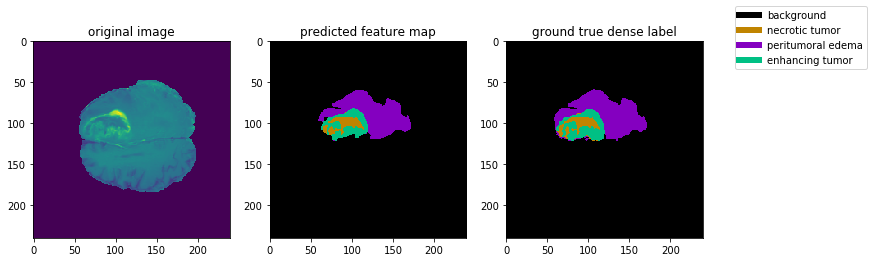

In [37]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path=base_path, img_name='Brats18_TCIA06_372_1_099')